# Wide Conv Experiment Results

In [28]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [29]:
%matplotlib inline

In [30]:
sns.set_style("whitegrid")

In [31]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-wideconv-fix-params-and-seed',))]

In [32]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] not in ('mpcnn', 'mpcnn_no_per_dim_no_multi_pooling'):
        continue
    
    if 'wide_conv' in args:
        arch = 'Wide Conv'
    else:
        arch = 'Narrow Conv'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [33]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [34]:
trecqa['seed'].unique()

array([428038, 765364, 384200, 843412, 581900, 243649, 160893, 929510,
       474441, 900850])

In [35]:
trecqa['arch'].unique()

array(['Narrow Conv', 'Wide Conv'], dtype=object)

In [36]:
archs = ['Narrow Conv', 'Wide Conv']
def compare_change_to_baseline(df, metric):
    changes = {'Narrow Conv': 'baseline'}
    config_ids = df['seed'].unique()
    for arch in archs:
        if arch == 'Narrow Conv':
            continue

        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'Narrow Conv')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')
        diff = np.median(diffs)
        changes[arch] = f'+{diff:.4f}' if diff > 0 else f'{diff:.4f}'
    
    return changes

## TrecQA

In [37]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [38]:
trec_map_intervals = {}
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Narrow Conv: (0.7676, 0.7844)
Wide Conv: (0.7649, 0.7846)


In [39]:
trec_mrr_intervals = {}
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Narrow Conv: (0.8317, 0.8493)
Wide Conv: (0.8347, 0.8553)


In [40]:
trec_map_delta = compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Wide Conv
Median of MAP change compared with single baseline: -0.0035
Mean of MAP change compared with single baseline: -0.0012


In [41]:
trec_mrr_delta = compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Wide Conv
Median of MRR change compared with single baseline: 0.0070
Mean of MRR change compared with single baseline: 0.0045


## WikiQA

In [42]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [43]:
wikiqa_map_intervals = {}
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Narrow Conv: (0.6831, 0.6999)
Wide Conv: (0.6874, 0.7025)


In [44]:
wikiqa_mrr_intervals = {}
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Narrow Conv: (0.6975, 0.7151)
Wide Conv: (0.7021, 0.7183)


In [45]:
wikiqa_map_delta = compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Wide Conv
Median of MAP change compared with single baseline: 0.0020
Mean of MAP change compared with single baseline: 0.0034


In [46]:
wikiqa_mrr_delta = compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Wide Conv
Median of MRR change compared with single baseline: 0.0021
Mean of MRR change compared with single baseline: 0.0039


## SICK

In [47]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [48]:
sick_pearson_intervals = {}
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_pearson_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Narrow Conv: (0.8634, 0.8701)
Wide Conv: (0.8709, 0.8763)


In [49]:
sick_spearman_intervals = {}
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_spearman_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

Narrow Conv: (0.7995, 0.8065)
Wide Conv: (0.8097, 0.8175)


In [50]:
sick_pearson_delta = compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Wide Conv
Median of pearson change compared with single baseline: 0.0062
Mean of pearson change compared with single baseline: 0.0068


In [51]:
sick_spearman_delta = compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Wide Conv
Median of spearman change compared with single baseline: 0.0088
Mean of spearman change compared with single baseline: 0.0106


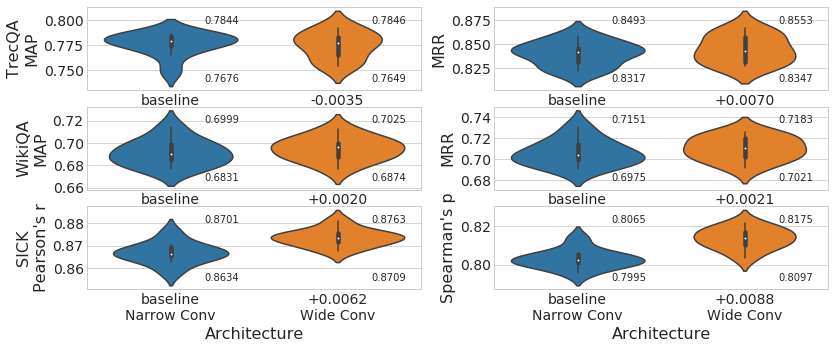

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 6)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('TrecQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.8*(ylim[1] - ylim[0]), trec_map_intervals[a][1])

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.8*(ylim[1] - ylim[0]), trec_mrr_intervals[a][1])

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('WikiQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.8*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][1])

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.8*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][1])

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("SICK\nPearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_pearson_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_pearson_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.8*(ylim[1] - ylim[0]), sick_pearson_intervals[a][1])

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_spearman_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_spearman_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.8*(ylim[1] - ylim[0]), sick_spearman_intervals[a][1])
plt.tight_layout()
plt.subplots_adjust(top=0.8, hspace=0.2)
plt.savefig('wideconv_model_violin.pdf')